# Light curves augmentation using neural networks

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import warnings
warnings.filterwarnings('ignore', 'lbfgs failed to converge*')

import aug_functions
import utils

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

### Data download

In [3]:
good_objects_df = pd.read_csv("../data/plasticc/good_objects.csv", index_col=0)
good_objects_df.sample(10)

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
5117729,162611,60608.1569,4,14.830835,1.698303,1,3.938479,0
1908036,61332,60045.0129,2,29.108419,1.048247,1,3.790512,1
21139660,7197567,60038.3317,5,228.582855,25.369164,1,3.987288,0
6932975,219261,59988.1595,4,42.741539,2.747985,1,3.938479,1
3006567,96265,59770.3817,3,18.635004,1.074258,1,3.875155,0
9712620,307165,60596.1427,1,39.310013,3.499361,1,3.675929,0
6140341,194256,59839.1159,5,28.942665,4.772209,1,3.987288,0
200878,103162,59854.0950,3,368.263611,2.437087,1,3.875155,1
1425740,45849,60567.4024,4,56.450657,3.043634,1,3.938479,1
492340,245390,59902.1537,3,206.664536,2.260388,1,3.875155,0


In [4]:
good_object_ids = np.unique(good_objects_df.object_id)

### An example of augmentation model work

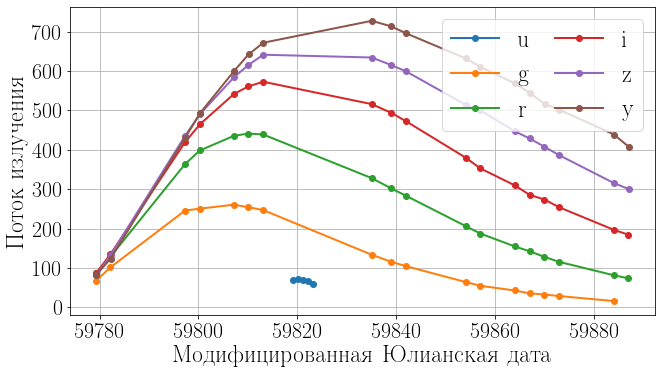

In [5]:
anobject = aug_functions.get_object(good_objects_df, 34299)

aug_functions.plot_light_curves(anobject)

In [6]:
anobject.head()

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
65498,34299,59779.3188,2,87.794540,2.394942,1,3.790512,0
65499,34299,59779.3265,1,68.224197,2.879688,1,3.675929,0
65500,34299,59779.3342,3,87.452316,2.326311,1,3.875155,0
65501,34299,59779.3452,4,81.765785,3.025279,1,3.938479,0
65502,34299,59779.3562,5,82.755684,7.136933,1,3.987288,0


In [7]:
augmentation_model = "MLP"

RMSE:  4.463562079470353
MAE:  3.7543163642979556
RSE:  0.02121884706688703
RAE:  0.020046293702703444
MAPE:  2.43556937528598


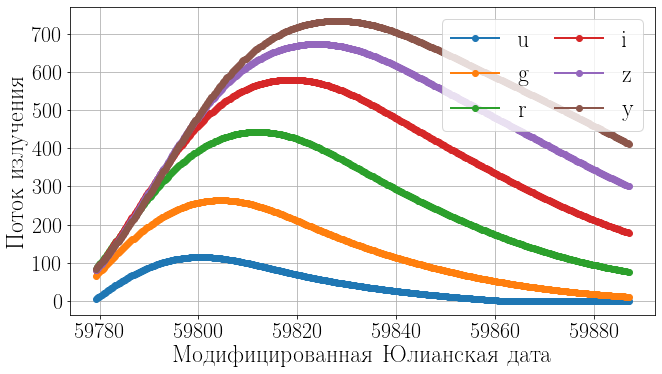

In [8]:
from sklearn.model_selection import train_test_split

# train/test split data
anobject = aug_functions.get_object(good_objects_df, 34299)
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

# select augmentation model
model = None
if augmentation_model == "GP":
    import gp_aug
    model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
elif augmentation_model == "NN":
    import single_layer_aug
    model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
elif augmentation_model == "FE":
    import features_aug
    model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
elif augmentation_model == "MLP":
    import mlp_aug
    model = mlp_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
elif augmentation_model == "RBF":
    import rbfnet_aug
    model = rbfnet_aug.RBFNetAugmentation(aug_functions.passband2lam)
elif augmentation_model == "BNN":
    import bnn_aug
    model = bnn_aug.BayesianNetAugmentation(aug_functions.passband2lam)
elif augmentation_model == "NF":
    import nf_aug
    model = nf_aug.NFAugmentation(aug_functions.passband2lam)
else:
    raise ValueError("Unknown augmentation type: {}".format(augmentation_model))
    
# fit augmentation model
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=aug_functions.N_OBS)
anobject_test_pred = anobject_test.copy()
anobject_test_pred['flux'], anobject_test_pred['flux_err'] = flux_pred, flux_err_pred

# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'])
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

# visualize augmented light curve
anobject_aug = aug_functions.compile_obj(t_aug, flux_aug, flux_err_aug, passbands_aug)
anobject_aug["object_id"] = anobject.object_id.to_numpy()[0]
aug_functions.plot_light_curves(anobject_aug, "aug")

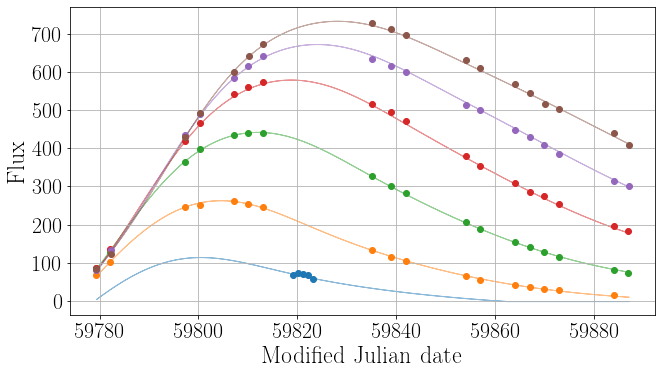

In [9]:
anobject_pic_real = anobject.sort_values('mjd')
anobject_pic_aug = anobject_aug.sort_values('mjd')
colors = ['C' + str(i) for i in range(6)]

fig = plt.figure(figsize=(9, 5), tight_layout = {'pad': 0})
for passband in range(6):
    light_curve_real = aug_functions.get_passband(anobject_pic_real, passband)
    light_curve_aug = aug_functions.get_passband(anobject_pic_aug, passband)
    plt.plot(light_curve_real['mjd'].values, light_curve_real['flux'].values, 'o', linewidth=2)
    plt.fill_between(light_curve_aug['mjd'].values,
                     light_curve_aug['flux'].values - 3 * light_curve_aug['flux_err'].values,
                     light_curve_aug['flux'].values + 3 * light_curve_aug['flux_err'].values,
                     label=aug_functions.passband2name[passband], alpha=0.5, color=colors[passband])
#plt.title('Ожидаемый разброс значений $\hat{f}(x) \pm 3 \sigma$', fontsize=28, pad=8.0)
plt.xlabel('Modified Julian date', fontsize=24)
plt.xticks(fontsize=22)
plt.ylabel('Flux', fontsize=24)
plt.yticks(fontsize=22)
#plt.legend(loc='upper right', ncol=2, fontsize=24, columnspacing=1.0)
plt.grid(True)
plt.show()
#fig.savefig("../pictures/light_curve_{}_{}.pdf".format(anobject.object_id.to_numpy()[0], 
#            augmentation_model), bbox_inches='tight', pad_inches=0.0)#

### Solution of the regression problem

In [10]:
from joblib import Parallel, delayed

In [11]:
def one_object_test(good_id):
    # get an object
    anobject = aug_functions.get_object(good_objects_df, good_id)

    # train / test split data
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)
    
    # select augmentation model
    model = None
    if augmentation_model == "GP":
        import gp_aug # стереть
        model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "NN":
        model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "FE":
        model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "MLP":
        model = mlp_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "RBF":
        model = rbfnet_aug.RBFNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "BNN":
        model = bnn_aug.BayesianNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "NF":
        model = nf_aug.NFAugmentation(aug_functions.passband2lam)
    else:
        raise ValueError("Unknown augmentation type")
        
    # fil augmentation model
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)

    # calculate metrics
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                           flux_pred.reshape((1, -1))[0])
    return metrics

In [12]:
def gen_report(metrics):
    report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = [i] + list(met)
    return report

In [13]:
%%time

metrics = Parallel(n_jobs=-1)(delayed(one_object_test)(good_id) for good_id in good_object_ids)
report  = gen_report(metrics)
metrics = report

df_metrics = pd.DataFrame(data=metrics, columns=["RMSE", "MAE", "RSE", "RAE", "MAPE"])
df_metrics.mean()

CPU times: user 8.78 s, sys: 342 ms, total: 9.12 s
Wall time: 44 s


RMSE    19.732074
MAE     10.701161
RSE      0.352357
RAE      0.297120
MAPE    17.450878
dtype: float64

In [14]:
# sample metric values

rmse = np.array(report)[:,1]
mae  = np.array(report)[:,2]
rse  = np.array(report)[:,3]
rae  = np.array(report)[:,4]
mape = np.array(report)[:,5]

N = len(good_object_ids)
assert len(rmse) == N
assert len(mae) == N
assert len(rse) == N
assert len(rae) == N
assert len(mape) == N

np.random.seed(127)
sample_coeffs = np.random.randint(0, N, (10000, 1000))

# calculate mean RMSE
sample_rmse = rmse[sample_coeffs]
sample_rmse_mean = sample_rmse.mean(axis=1)
print("RMSE: mean = %.4f, std = %.4f" % (sample_rmse_mean.mean(), sample_rmse_mean.std()))

# calculate mean MAE
sample_mae = mae[sample_coeffs]
sample_mae_mean = sample_mae.mean(axis=1)
print("MAE:  mean = %.4f, std = %.4f" % (sample_mae_mean.mean(), sample_mae_mean.std()))

# calculate mean RSE
sample_rse = rse[sample_coeffs]
sample_rse_mean = sample_rse.mean(axis=1)
print("RSE:  mean = %.4f,  std = %.4f" % (sample_rse_mean.mean(), sample_rse_mean.std()))

# calculate mean RAE
sample_rae = rae[sample_coeffs]
sample_rae_mean = sample_rae.mean(axis=1)
print("RAE:  mean = %.4f,  std = %.4f" % (sample_rae_mean.mean(), sample_rae_mean.std()))

# calculate mean MAPE
sample_mape = mape[sample_coeffs]
sample_mape_mean = sample_mape.mean(axis=1)
print("MAPE: mean = %.4f, std = %.4f" % (sample_mape_mean.mean(), sample_mape_mean.std()))

RMSE: mean = 19.7467, std = 7.3267
MAE:  mean = 10.7078, std = 2.8411
RSE:  mean = 0.3523,  std = 0.0094
RAE:  mean = 0.2971,  std = 0.0076
MAPE: mean = 17.4472, std = 0.4592


#### Table of the direct metrics:

|Model|RMSE         | MAE        | RSE               | RAE               | MAPE           | Time      |
|:----|:-----------:|:----------:|:-----------------:|:-----------------:|:--------------:|:---------:|
|GP   | $18$ ± $6$  | $11$ ± $3$ | $0.305$ ± $0.007$ | $0.265$ ± $0.005$ | $20.0$ ± $0.7$ | $02$:$38$ |
|NN1  | $28$ ± $11$ | $17$ ± $6$ | $0.371$ ± $0.006$ | $0.327$ ± $0.005$ | $22.1$ ± $0.6$ | $11$:$21$ |
|FE   | $21$ ± $8$  | $13$ ± $4$ | $0.317$ ± $0.005$ | $0.283$ ± $0.005$ | $17.8$ ± $0.3$ | $13$:$5$ |
|MLP  | $19$ ± $7$  | $11$ ± $3$ | $0.347$ ± $0.009$ | $0.292$ ± $0.007$ | $17.2$ ± $0.5$ | $\textbf{00}$**:**$\textbf{43}$ |
|BNN  | $20$ ± $7$  | $12$ ± $3$ | $0.353$ ± $0.009$ | $0.306$ ± $0.007$ | $19.3$ ± $0.5$ | $37$:$12$ |
|NF   | $20$ ± $10$ | $10$ ± $4$ | $\textbf{0.302}$ **±** $\textbf{0.007}$ | $\textbf{0.249}$ **+** $\textbf{0.005}$ | $\textbf{15.5}$ **±** $\textbf{0.4}$ | $6$:$02$:$51$

### Solution of the classification problem

In [15]:
from tqdm.notebook import tqdm

def gen_one_object(good_id):
    # train / test split data
    anobject = aug_functions.get_object(good_objects_df, good_id)
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

    # initialize augmentation model
    model = None
    if augmentation_model == "GP":
        model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "NN":
        model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "FE":
        model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "MLP":
        model = mlp_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "RBF":
        model = rbfnet_aug.RBFNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "BNN":
        model = bnn_aug.BayesianNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "NF":
        model = nf_aug.NFAugmentation(aug_functions.passband2lam)
    else:
        raise ValueError("Unknown augmentation type")

    # fit augmentation model
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)

    # augmentation
    t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                      anobject['mjd'].max(), 
                                                                      n_obs=aug_functions.N_OBS)

    # convert values to 2D-array
    data_array = flux_aug.reshape((aug_functions.N_PASSBANDS, aug_functions.N_OBS)).T
    
    # add target value for this curve
    true_class = int(anobject['class'].to_numpy()[0])
    
    return (true_class, [data_array])

In [16]:
%%time

some_array = Parallel(n_jobs=-1)(delayed(gen_one_object)(good_id) for good_id in good_object_ids)

# collect all input data
all_target_classes = np.array([some_array[i][0] for i in range(len(some_array))])
all_data = np.array([some_array[i][1] for i in range(len(some_array))])
print(all_data.shape, all_target_classes.shape)

(2508, 1, 500, 6) (2508,)
CPU times: user 8.28 s, sys: 364 ms, total: 8.65 s
Wall time: 43.3 s


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

device = 'cpu'

In [18]:
# train / test split data
X_train, X_test, y_train, y_test = train_test_split(all_data, 
                                                    all_target_classes,
                                                    test_size=0.4,
                                                    random_state=179)

# normalize input data
X_train_norm = np.array((X_train - X_train.mean()) / X_train.std(), dtype=np.float32)
X_test_norm = np.array((X_test - X_train.mean()) / X_train.std(), dtype=np.float32)

# convert train data to tensors
X_train_tensor = torch.from_numpy(X_train_norm)
y_train_tensor = torch.from_numpy(np.array(y_train, dtype=np.float32))

batch = 16
# create train data loader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch,
                                          shuffle=True, num_workers=2)

# convert test data to tensors
X_test_tensor = torch.from_numpy(X_test_norm)
y_test_tensor = torch.from_numpy(np.array(y_test, dtype=np.float32))

# create test data loader
test_data = TensorDataset(X_test_tensor, y_test_tensor)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                         shuffle=False, num_workers=2)

In [19]:
# model for binary classificiation: Supernova Ia VS others

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(10, 2))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(15, 2))
        self.conv3 = nn.Conv1d(8, 8, kernel_size=(5, 2))
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(3808, 64) #
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
#        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = x.view(-1, 3808) # 3824
        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [20]:
import torch.optim as optim

# initialize binary classifier
net = Net()
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)

In [21]:
def get_model_accuracy(net, data_loader, batch_size):
    correct = 0
    total = 0

    with torch.no_grad():
        for test_info in data_loader:
            images, test_labels = test_info
            test_outputs = net(images).reshape(batch_size)
            for prob, ans in zip(test_outputs.detach().numpy(), test_labels.detach().numpy()):
                if prob > 0.5:
                    predicted = 1
                else:
                    predicted = 0
                total += 1
                correct += (predicted == ans)

    return correct / total

In [22]:
from copy import deepcopy

epochs = np.arange(250)

best_loss = float('inf')
best_state = None
loss_history = []
test_history = []

for epoch in tqdm(epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    for info in trainloader:
        # get the inputs; info is a list of [inputs, labels]
        inputs, labels = info

        # zero the parameter gradients
        for param in net.parameters():
            param.grad = None
        
        # forward + backward + optimize
        outputs = net(inputs).reshape(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # print mean loss for the epoch
    cur_loss = epoch_loss / X_train_norm.shape[0]
    loss_history.append(cur_loss)
    
    if (epoch + 1) % 10 == 0:
        print('[%5d] error: %.3f' % (epoch + 1, cur_loss))
    if cur_loss <= best_loss:
        best_loss = cur_loss
        best_state = deepcopy(net.state_dict())
    
    test_loss = 0.0
    for info in testloader:
        inputs, labels = info
        outputs = net(inputs).reshape(1)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    test_loss /= X_test_norm.shape[0]
    test_history.append(test_loss)

net.load_state_dict(best_state)

print('Finished Training')

  0%|          | 0/250 [00:00<?, ?it/s]

/home/katsam/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[   10] error: 0.332
[   20] error: 0.251
[   30] error: 0.221
[   40] error: 0.197
[   50] error: 0.189
[   60] error: 0.175
[   70] error: 0.166
[   80] error: 0.160
[   90] error: 0.227
[  100] error: 0.143
[  110] error: 0.135
[  120] error: 0.127
[  130] error: 0.124
[  140] error: 0.122
[  150] error: 0.112
[  160] error: 0.105
[  170] error: 0.106
[  180] error: 0.102
[  190] error: 0.098
[  200] error: 0.095
[  210] error: 0.088
[  220] error: 0.080
[  230] error: 0.082
[  240] error: 0.076
[  250] error: 0.079
Finished Training


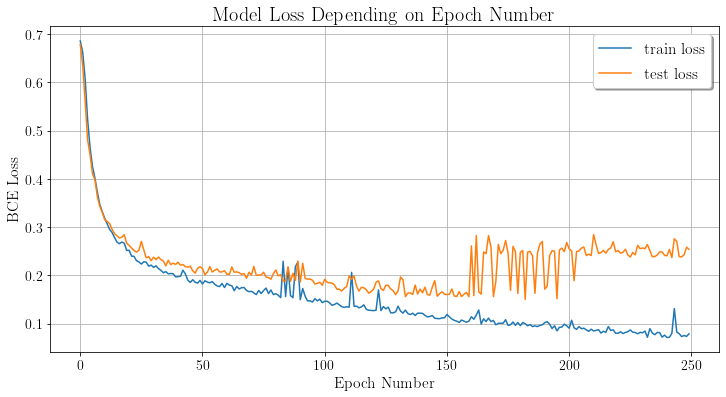

In [23]:
fig = plt.figure(figsize=(12, 6))
plt.title("Model Loss Depending on Epoch Number", fontsize=20)
plt.plot(loss_history, label="train loss")
plt.plot(test_history, label="test loss")
plt.legend(loc="best", shadow=0.1, fontsize=16)
plt.xlabel("Epoch Number", fontsize=16)
plt.ylabel("BCE Loss", fontsize=16)
#plt.yscale("log")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()
#fig.savefig("../pictures/epoch_test_train_loss.pdf", bbox_inches='tight')

In [24]:
net.load_state_dict(best_state)
net.eval()

# check models' accuracy
train_accuracy = get_model_accuracy(net, trainloader, batch)
test_accuracy = get_model_accuracy(net, testloader, 1)

print('Test accuracy of the network on the %d test images: %.4f' % 
      (X_test_norm.shape[0], test_accuracy))
print('Train accuracy of the network on the %d train images: %.4f' % 
      (X_train_norm.shape[0], train_accuracy))

Test accuracy of the network on the 1004 test images: 0.9492
Train accuracy of the network on the 1504 train images: 0.9761


In [25]:
# MLP: 0.9323

In [26]:
y_test = []
y_probs = []
y_probs_0 = []
y_probs_1 = []

with torch.no_grad():
    for test_info in testloader:
        images, test_labels = test_info
        test_outputs = net(images)
        
        # get output value
        prob = test_outputs.item()
        
        # check true target valur    
        true_class = int(test_labels.item())
        
        # compare output to threshold
        if true_class == 0:
            y_probs_0.append(prob)
        else:
            y_probs_1.append(prob)
        
        # get predicted target value
        y_test.append(true_class)
        y_probs.append(prob)
        
y_test = np.array(y_test)
y_probs = np.array(y_probs)

assert np.array(y_probs).min() >= 0
assert np.array(y_probs).max() <= 1

In [27]:
N = len(y_probs)

# sample predicted values
sample_coeffs = np.random.randint(0, N, (10000, 1000))
sample_prob = y_probs[sample_coeffs]
sample_test = y_test[sample_coeffs]
sample_pred = sample_prob > 0.5

assert len(sample_test) == len(sample_prob)
assert len(sample_prob) == len(sample_pred)
T = len(sample_test)

# calculated mean accuracy
accuracy = [(sample_pred[i] == sample_test[i]).mean() for i in range(T)]

In [28]:
from sklearn.metrics import log_loss

y_pred = np.array(y_probs) > 0.5
print("LogLoss = %.4f" % log_loss(y_test, y_pred))

# calculate mean log loss
logloss = [log_loss(sample_test[i], sample_pred[i]) for i in range(T)]

LogLoss = 1.7545


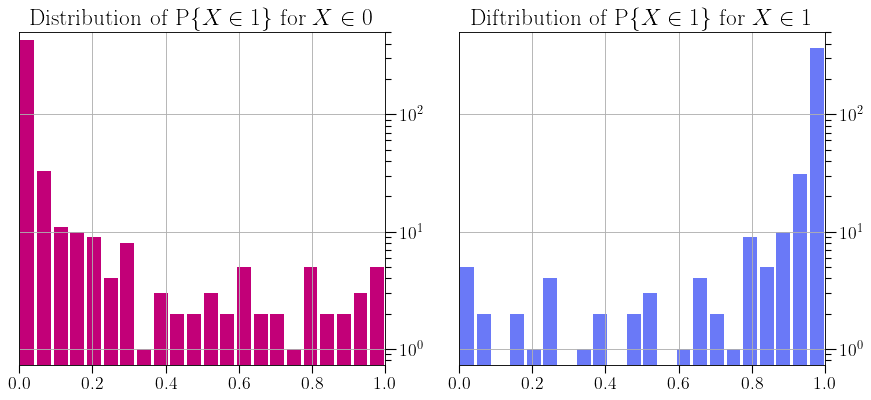

In [29]:
# compare distibution of output values

rc('xtick', labelsize=16)
rc('ytick', labelsize=16)

fig = plt.figure(dpi=80, figsize=(13, 5.5))

bins_number = 22
step = 1 / bins_number
hist_0, _ = np.histogram(y_probs_0, bins=bins_number, range=(0.0, 1.0))
hist_1, _ = np.histogram(y_probs_1, bins=bins_number, range=(0.0, 1.0))
x = np.arange(0 + step/2, 1, step)

ax1 = fig.add_subplot(121)
ax1.yaxis.tick_right()
plt.title("Distribution of P$\{X \in 1\}$ for $X \in 0$", fontsize=21, pad=7)

ax1.bar(x, hist_0, color="xkcd:magenta", width=0.038, log=True)
ax1.minorticks_on()
ax1.tick_params('y', length=10, width=1, which='major')
ax1.tick_params('y', length=5, width=1, which='minor')
ax1.tick_params('x', length=7, width=1, which='major')
ax1.tick_params('x', length=0, width=1, which='minor')
plt.xlim((0.0, 1.0))
plt.ylim((ax1.get_ylim()[0], int(ax1.get_ylim()[1]) // 100 * 100))
plt.grid(True)

ax2 = fig.add_subplot(122)
ax2.yaxis.tick_right()
plt.title("Diftribution of P$\{X \in 1\}$ for $X \in 1$", fontsize=21, pad=7)

ax2.bar(x, hist_1, color="xkcd:cornflower", width=0.038, log=True)
ax2.minorticks_on()
ax2.tick_params('y', length=10, width=1, which='major')
ax2.tick_params('y', length=5, width=1, which='minor')
ax2.tick_params('x', length=7, width=1, which='major')
ax2.tick_params('x', length=0, width=1, which='minor')
plt.xlim((0.0, 1.0))
plt.ylim(ax1.get_ylim())
plt.grid(True)

plt.show()

#fig.savefig("../pictures/CNN_output_hist_2_{}.pdf".format(augmentation_model),
#           bbox_inches='tight')

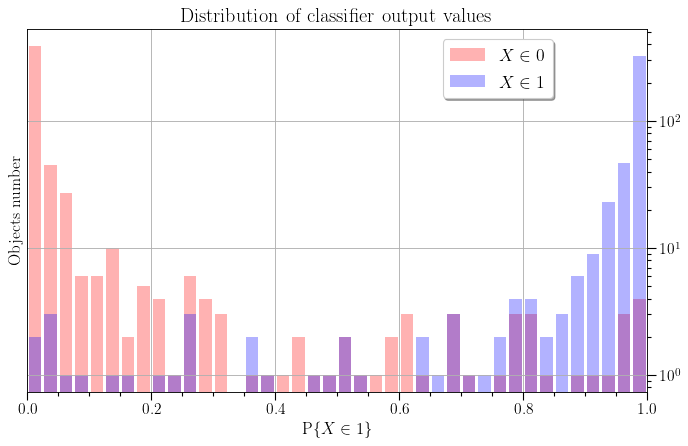

In [30]:
# compare distibution of output values

rc('xtick', labelsize=14)
rc('ytick', labelsize=14)

fig = plt.figure(dpi=80, figsize=(10, 6))
ax = fig.add_subplot(111)
ax.yaxis.tick_right()

plt.title("Distribution of classifier output values", fontsize=18, pad=7)
plt.xlabel("P$\{X \in 1\}$", fontsize=15)
plt.ylabel("Objects number", fontsize=15)

bins_number = 40
step = 1 / bins_number
hist_0, _ = np.histogram(y_probs_0, bins=bins_number, range=(0.0, 1.0))
hist_1, _ = np.histogram(y_probs_1, bins=bins_number, range=(0.0, 1.0))
x = np.arange(0 + step/2, 1, step)

plt.bar(x, hist_0, color='r', width=0.02, log=True, label="$X \in 0$", alpha=0.3)
plt.bar(x, hist_1, color='b', width=0.02, log=True, label="$X \in 1$", alpha=0.3)

ax.minorticks_on()
ax.tick_params('y', length=8, width=1, which='major')
ax.tick_params('y', length=4, width=1, which='minor')
ax.tick_params('x', length=7, width=1, which='major')
ax.tick_params('x', length=4, width=1, which='minor')

plt.xlim((0.0, 1.0))
plt.grid(True)
plt.legend(frameon=True, loc=(0.67, 0.81), fontsize=16, shadow=0.1)

plt.show()

#fig.savefig("../pictures/CNN_output_hist_1_{}.pdf".format(augmentation_model),
#           bbox_inches='tight', pad_inches=0.01)

Test ROC-AUC: 0.9870, test PR-AUC: 0.9774


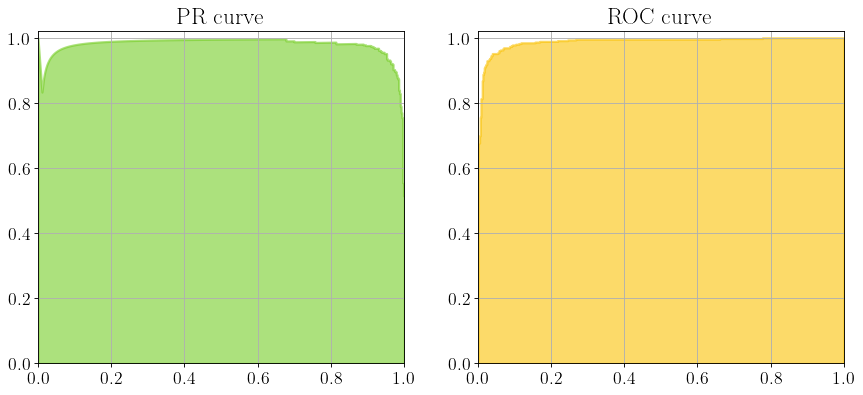

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

rc('xtick', labelsize=16)
rc('ytick', labelsize=16)

print("Test ROC-AUC: %.4f, test PR-AUC: %.4f" % (roc_auc_score(y_test, y_probs), 
                                                 average_precision_score(y_test, y_probs)))

# calculate mean AUC-ROC & AUC-PR
auc_roc = [roc_auc_score(sample_test[i], sample_prob[i]) for i in range(T)]
auc_pr = [average_precision_score(sample_test[i], sample_prob[i]) for i in range(T)]

precision, recall, _ = precision_recall_curve(y_test, y_probs)

fig = plt.figure(dpi=80, figsize=(13, 5.5))
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

ax = fig.add_subplot(122)
plt.grid(True)
ax.set_title("ROC curve", fontsize=21, pad=7)
ax.fill_between(fpr, tpr, alpha=0.6, color="xkcd:goldenrod", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.02)

ax = fig.add_subplot(121)
plt.grid(True)
ax.set_title("PR curve", fontsize=21, pad=7)
ax.fill_between(recall, precision, alpha=0.6, color="xkcd:apple green", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.02)

plt.show()

#fig.savefig("../pictures/CNN_pr_roc_curves_{}.pdf".format(augmentation_model), 
#            bbox_inches='tight')

In [32]:
print("AUC-ROC:  mean = %.4f, std = %.4f" % (np.mean(auc_roc), np.std(auc_roc)))
print("AUC-PR:   mean = %.4f, std = %.4f" % (np.mean(auc_pr), np.std(auc_pr)))
print("Accuracy: mean = %.4f, std = %.4f" % (np.mean(accuracy), np.std(accuracy)))
print("LogLoss:  mean = %.4f, std = %.4f" % (np.mean(logloss), np.std(logloss)))

AUC-ROC:  mean = 0.9870, std = 0.0034
AUC-PR:   mean = 0.9780, std = 0.0103
Accuracy: mean = 0.9492, std = 0.0069
LogLoss:  mean = 1.7561, std = 0.2392


#### Summary metric tables for augmentation models

#### Table of the indirect metrics:

|Model|AUC-ROC            |AUC-PR           |Accuracy           |LogLoss        |Complexity|
|:----|:-----------------:|:---------------:|:-----------------:|:-------------:|:--------:|
|GP   | $0.986$ ± $0.003$ | $0.98$ ± $0.01$ | $0.947$ ± $0.007$ | $1.8$ ± $0.2$ | $O(N^3)$ |
|NN1  | $0.983$ ± $0.005$ | $0.97$ ± $0.01$ | $0.925$ ± $0.008$ | $2.0$ ± $0.3$ | $O(N)$   |
|FE   | $0.981$ ± $0.004$ | $0.98$ ± $0.01$ | $0.948$ ± $0.008$ | $1.9$ ± $0.3$ | $O(N)$   |
|MLP  | $\textbf{0.988}$ **±** $\textbf{0.003}$ | $0.98$ ± $0.01$ | $\textbf{0.950}$ **±** $\textbf{0.007}$ | $\textbf{1.7}$ **±** $\textbf{0.2}$ | $O(N)$   |
|BNN  | $0.984$ ± $0.004$ | $0.98$ ± $0.01$ | $0.941$ ± $0.008$ | $2.0$ ± $0.3$ | $O(N)$   |
|NF   | $0.985$ ± $0.004$ | $0.97$ ± $0.01$ | $0.949$ ± $0.007$ | $1.8$ ± $0.2$ | ???      |